### Dataset To Database

Map each record directory:

In [1]:
import os

records_list = os.listdir('./data/')

part_codes = sorted(list(set([record.split('/')[0] for record in records_list])))

Read summary in data/ directory:

In [2]:
import os

def get_summary_info( record ):
    directory = "data/" + record + '/'
    filename = record + '-summary.txt'
    fullpath = os.path.join( directory, filename )

    with open(fullpath, encoding='UTF-8') as f:
      content = f.readlines()
      f.close()

    return content

Convert summary content to variables and insert it to the database if the corresponding .edf file exists:

In [3]:
import re
import database.database_utils as db

def summary_info(content, record_name):

  nr_channels = 0
  file_name = ""
  start_time = ""
  end_time = ""
  start_seizure = []
  end_seizure = []
  nr_seizures = ""
  ds_channels = []

  for line in content:

    if re.findall('Channel \d+', line):
      nr_channels += 1
      channel = re.findall(line.split(': ')[1], line)[0].replace("\n", "")
      ds_channels.append(channel)

    elif re.findall('Channels changed', line):
      nr_channels = 0
      ds_channels.clear()

    elif re.findall('File Name', line):
      file_name = re.findall('\w+_\w+.\.edf', line)[0]

    elif re.findall('File Start Time', line):
      start_time = re.findall('\d+:\d+:\d+', line)[0]

    elif re.findall('File End Time', line):
      end_time = re.findall('\d+:\d+:\d+', line)[0]

    elif re.findall('(Seizure \d+ Start Time|Seizure Start Time)', line):
      seizure = re.findall('\d+', line.split(': ')[1])[0].replace("\n", "")
      start_seizure.append(seizure)

    elif re.findall('(Seizure \d+ End Time|Seizure End Time)', line):
      seizure = re.findall('\d+', line.split(': ')[1])[0].replace("\n", "")
      end_seizure.append(seizure)

    elif re.findall('Number of Seizures in File', line):
      nr_seizures = re.findall('\d+', line)[0]

    else:
      if file_name != "":
        directory = "./data/" + record_name + '/'
        fullpath = os.path.join( directory, file_name )

        if os.path.exists( fullpath ):
            if db.summary_by_name(file_name) == None:
              print("Inserindo: " + file_name)
              db.insert_sumarry_data(record_name,
                                    file_name,
                                    start_time,
                                    end_time,
                                    int(nr_seizures),
                                    ','.join(start_seizure),
                                    ','.join(end_seizure),
                                    nr_channels,
                                    ','.join(ds_channels))
            else:
              print("Registro já inserido: " + file_name)

        file_name = ""
        start_time = ""
        end_time = ""
        start_seizure.clear()
        end_seizure.clear()
        nr_seizures = ""

Reads, convert and insert (if dont exists in database) all summaries with downloaded file:

In [ ]:
for record in part_codes:
    record_context = get_summary_info(record)
    summary_info(record_context, record)

The result is the following populated table:

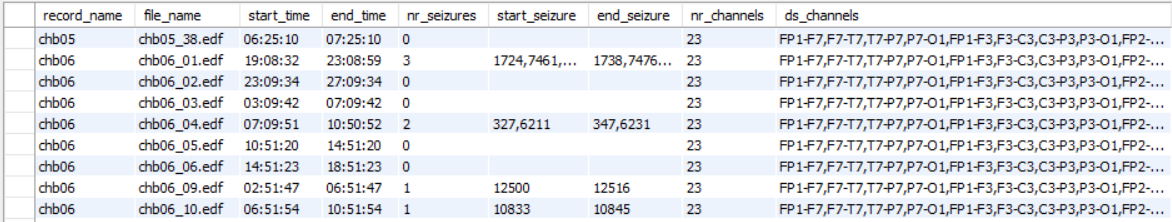